# 순환 신경망으로 IMDB 리뷰 분류하기

## IMDB 리뷰 데이터셋
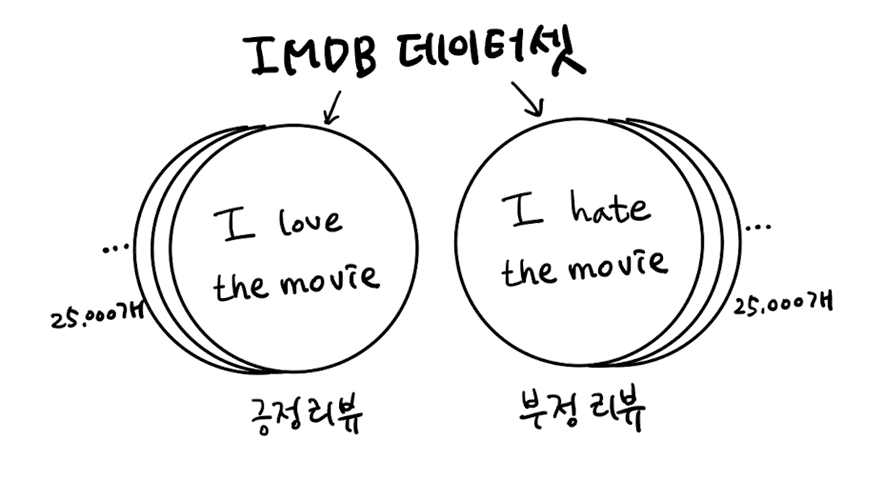

### 텍스트  데이터 처리
- 텍스트 데이터 자체를 신경망에 전달할 수는 없음
    - 컴퓨터에서 처리하는 모든 것은 어떤 숫자 데이터 임
    - 이미지는 그 자체가 픽셀값(수치)으로 표현되어 있어 변환이 필요 없음
    - 텍스트는 단어를 숫자로 바꿔 줘야 함
    - 가장 생각하기 쉬운 단어를 숫자로 바꾸는 방법은?
        - 단어마다 고유한 정수를 부여하는 방법
        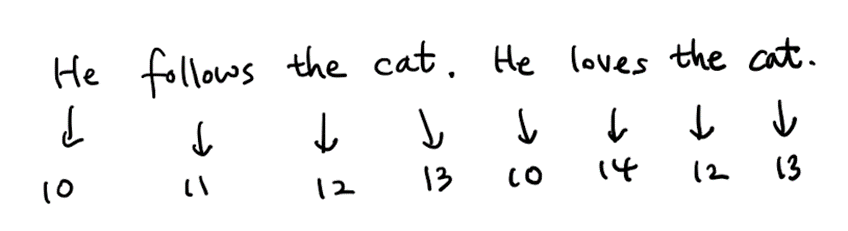
        - 동일한 단어는 동일한 정수에 매핑되고 정수들은 어떠한 관계도 없음(물론, 크기 차이도 의미 없음)
        - 일반적으로 영어 문장은 모두 소문자로 바꾸로 구둣점 삭제 후 공백을 기준으로 분리
            - 이렇게 분리된 단어를 토큰이라고 함
            - **샘플은 여러개의 단어로 이루어져있고 1개의 토큰은 하나의 타임스탬프**
            - 정수에 사용되는 값 중 일부는 고유한 값으로 예약되어 있음
- 어휘 사전 : 훈련세트에서 고유한 단어를 뽑아만든 목록

### IMDB 데이터 셋
- 텐서플로가 제공하는 데이터 셋은 이미 정수로 바꾼 데이터 셋이 포함되어 있음
- 텍스트의 전처리가 완료된 dataset
    - voca(어휘사전)도 완료되어 있음
- 텐서플로가 제공하는 데이터셋은 이미 정수로 바꾼 데이터셋이 포함되어 있음

In [3]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

# 어휘사전에는 500개의 단어만 들어있다.
# 즉, 빈도수가 높은 500개의 단어만 이용 load 했다는 의미이므로
# 문장에서 빈도수가 낮은 단어는 500개에 없는 단어는 모두 2로 처리되어 있음
# 리뷰문장도 어휘사전에 있는 500개 단어에 대해서는 고유번호가 맵핑되어 있음

In [4]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [5]:
# 첫번째 리뷰 단어 길이 (단어 개수)
print(len(train_input[0]))

218


In [6]:
# 두번째 리뷰의 단어 길이
print(len(train_input[1]))

189


In [7]:
# 첫번째 리뷰 : 2는 어휘사전에 없는 단어 (빈도수가 낮은 단어)
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [8]:
# 리뷰가 긍정인지 부정인지 판단
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


### train data를 train과  val data로 분할

In [9]:
from sklearn.model_selection import train_test_split

# 8:2로 분할
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

###  train data 확인
- 분포 확인
    - 제일 많이 분포되어 있는 단어 수만큼만 사용
- 모자라는 문자는 패딩 처리

In [10]:
# 각 리뷰 길이 계산
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [11]:
# 전체 train_input 개수
len(lengths)  # 5000개는 validation이 가져감

20000

In [12]:
lengths[0]  # 첫 번재 학습리뷰 단어 수

259

In [13]:
# 평균길이와 길이의 중간값
print(np.mean(lengths), np.median(lengths))

# 길이가 아주 긴 리뷰 문장이 있다고 추정 가능

239.00925 178.0


#### 평균 단어 개수와 중간값의 차이가 좀 있어보임
- 분포는 한쪽으로 치우쳤을 것으로 예측

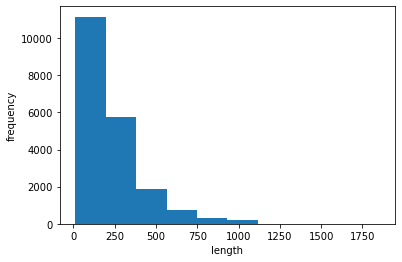

In [14]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

- 대부분의 리뷰 길이는 300 미만
    - 평균이 중간값보다 높은 이유는 오른쪽 끝에 아주 긴 리뷰가 있기 때문임
    - 많은 리뷰들이 100개 단어 이하로 분포되어 있음
    - 모든 리뷰의 단어를 다 사용하지 않고 100 단어 까지만 사용
        - 단어길이가 가장 많은 리뷰에 맞추려면 패딩을 많이 주입해야 함 (불필요한 타임스텝의 증가)

In [15]:
# 리뷰 단어가 100보다 작은것도 있으므로, 패딩을 이용해 단어 개수를 100으로 맞춤
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

In [16]:
print(train_seq.shape)  # 20000개의 데이터가 100개의 컬럼(토큰)으로 이루어져 있음

(20000, 100)


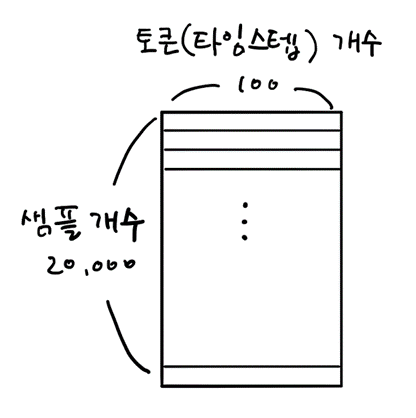

In [17]:
# 샘플의 앞뒤에 0이 없음 - 100 단어 이상 리뷰였을 것임
print(train_seq[0])  # 첫번째 리뷰

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


- 100단어 이상되는 리뷰는 앞 뒤 어디가 잘렸는지 확인

In [18]:
# 원본 리뷰의 끝 10단어와 비교
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


- train_seq[0](패딩된 data) 과 train_input[0](load data) 의 마지막 단어 값들이 동일하므로 앞단어가 잘림
    - 뒤로 갈수록 중요단어가 있다는 것을 기대하기 때문
        - 시퀀스 뒷부분을 잘라내고 싶다면 pad_sequence(truncation='post')로 설정

In [19]:
# 6번째 샘플을 보면 패딩이 되어 있음
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


### 검증세트도 훈련세트와 동일하게 패딩 진행

In [20]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기
- 케라스의 가장 간단한 순환 신경망 알고리즘
    - SimpleRNN(뉴런개수,입력차원)
    - 입력차원 : 100->100개의 단어로 맞춤 500 -> 500개의 빈도 높은 단어만 사용
        - 단어를 한 줄로 입력하면 단어의 정수값(의미없는)이 큰 단어는 큰 출력을 만들어 내버림
        - 그런 이유로 단어마다 동일한 가중치를 갖도록  one-hot 인코딩 해야 함
            - 임베딩이 아닌 one-hot 인코딩 방식으로 먼저 진행

In [21]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))  # 순환신경망층
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 출력층

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 패딩된 seq 데이터를 one-hot 인코딩 변환 후 모델 학습

In [23]:
# one-hot 인코딩 변환
train_oh = keras.utils.to_categorical(train_seq)

In [24]:
print(train_oh.shape)

(20000, 100, 500)


In [25]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [26]:
# 검증데이터도 변환
val_oh = keras.utils.to_categorical(val_seq)  # 원-핫인코딩

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


- 마지막 타임 스텝의 은닉상태만 출력 : 출력크기는 8
- 파라미터 크기 : 500차원의 입력층 * 뉴런 8 + 은닉층크기(뉴런수*뉴런수) 8 * 8 + 절편 8 => 4000+64+8 => 4072

## 순환 신경망 훈련하기
- 훈련 방법은 다른 알고리즘과 동일

In [28]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)  # adam 사용 가능
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 20000개의 샘플을 한번에 64개씩 끊어서 훈련 -> 313이 나옴

Epoch 1/100
313/313 [==============================] - 20s 58ms/step - loss: 0.6957 - accuracy: 0.5122 - val_loss: 0.6973 - val_accuracy: 0.4980
Epoch 2/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6924 - accuracy: 0.5236 - val_loss: 0.6946 - val_accuracy: 0.5120
Epoch 3/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6894 - accuracy: 0.5360 - val_loss: 0.6923 - val_accuracy: 0.5224
Epoch 4/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6866 - accuracy: 0.5486 - val_loss: 0.6899 - val_accuracy: 0.5320
Epoch 5/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6837 - accuracy: 0.5612 - val_loss: 0.6872 - val_accuracy: 0.5406
Epoch 6/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6803 - accuracy: 0.5737 - val_loss: 0.6840 - val_accuracy: 0.5536
Epoch 7/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6759 - accuracy: 0.5885 - val_loss: 0.6790 - val_ac

- 42번째 에포크에서 조기 종료
    - 3번 더 학습하고 조기종료 했으므로 39번째가 best 에포크
    - val_loss : 0.406, 정확도 78%
    - 아주 뛰어나지는 않지만 어느정도 성과는 있어보임

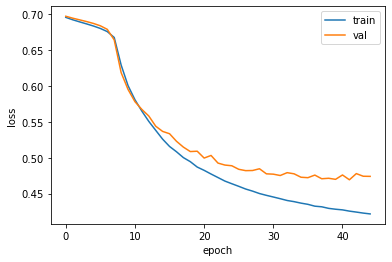

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 손실은 대략 20번째 에포크에서 둔해지고 있음
- 이 모델의 단점은 입력데이터가 엄청 커진다는데 있음

In [30]:
 print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


## 단어 임베딩을 사용하기
- 임베딩
    - 문장에서 단어가 나타나는 패턴을 고려해서 유사성이 높은 단어들은 비슷한 수치의 단어로 생성하자
        - 크기가 일정 범위 (-1 ~ +1 정도)의 숫자 n개를 활용해서 해당 단어 표현
        - cat과 dog가 나타나는 문장 패턴을 확인했을 때 love, house 단어와 주로 같이 나타난다고 판단되면
            - 이 두 단어는 유사성이 있다고 판단하고 n개의 수치 중 일부를 동일하게 처리
        - 이 작업을 모델에 embedding층을 추가해서 에포크가 한 번 반복될 때마다 유사성을 반영하도록 모델을 구성

In [31]:
model2 = keras.Sequential()

# 500개의 단어 한 개에 대하여 16개의 원소를 갖는 벡터로 변환 (밀집데이터)
model2.add(keras.layers.Embedding(500, 16, input_length=100))  # 입력층도 포함
model2.add(keras.layers.SimpleRNN(8))  # 쉘이 8개 있는 신경망 생성
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 이진분류이므로 1로 할당
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


- 임베딩 파라미터 : 500개의 단어 하나당 16개의 값을 갖는 벡터를 만들게 되므로 
    - 500 * 16 = 8000
- rnn : 임베딩 벡터 크기 16 * 뉴런 수 + 은닉층 크기(뉴런 수 x 뉴런 수 = 64) + 절편 8
    - 16*8 + 64 + 8 = 200

- 모델 훈련

In [32]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

In [50]:
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 21s 64ms/step - loss: 0.6947 - accuracy: 0.5096 - val_loss: 0.6915 - val_accuracy: 0.5168
Epoch 2/100
313/313 [==============================] - 20s 64ms/step - loss: 0.6806 - accuracy: 0.5806 - val_loss: 0.6724 - val_accuracy: 0.6266
Epoch 3/100
313/313 [==============================] - 20s 64ms/step - loss: 0.6560 - accuracy: 0.6646 - val_loss: 0.6463 - val_accuracy: 0.6892
Epoch 4/100
313/313 [==============================] - 20s 64ms/step - loss: 0.6261 - accuracy: 0.7108 - val_loss: 0.6184 - val_accuracy: 0.7094
Epoch 5/100
313/313 [==============================] - 20s 64ms/step - loss: 0.5937 - accuracy: 0.7373 - val_loss: 0.5884 - val_accuracy: 0.7320
Epoch 6/100
313/313 [==============================] - 20s 64ms/step - loss: 0.5638 - accuracy: 0.7564 - val_loss: 0.5609 - val_accuracy: 0.7526
Epoch 7/100
313/313 [==============================] - 20s 64ms/step - loss: 0.5394 - accuracy: 0.7709 - val_loss: 0.5402 - val_ac

- one-hot 인코딩과 비슷한 성능을 내지만 훈련세트 크기도 줄이고, 가중치의 개수도 훨씬 작음(더 가벼운 모델)    

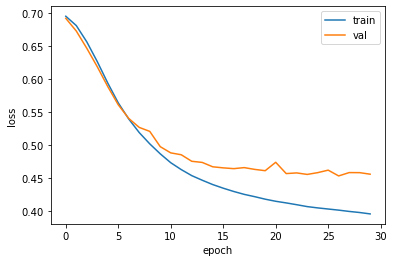

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()